# Install and import dependencies.

Make sure the python version is higher than 3.8 and lower than 3.12.

In [ ]:
!python3 --version

Python 3.11.13


Install pandasai 3.0.0b2 or newer.

In [ ]:
!pip install "pandasai>=3.0.0b2"

Intall pandasai liteLLM.

In [ ]:
!pip install pandasai-litellm

Import dependencies.

In [ ]:
import os
import io
import re
import time
import json
import random
import pandas as pd
import pandasai as pai
from getpass import getpass
from litellm import completion
from google.colab import files
from pandasai import SmartDataframe, SmartDatalake
from pandasai_litellm.litellm import LiteLLM
from pandasai.core.response.dataframe import DataFrameResponse

# Create new domain.

Input domain name.

In [ ]:
domain = input("Enter new domain name: ")

Enter new domain name: Campaign


Upload files.

In [ ]:
uploaded = files.upload(f"/domain/{domain}")

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Get list of the uploaded files.

In [ ]:
def list_files_in_directory(directory_path):
    """
    Lists all files within a specified directory.

    Args:
        directory_path (str): The path to the directory.

    Returns:
        list: A list of file names found in the directory.
    """
    files_in_directory = []
    try:
        all_entries = os.listdir(directory_path)

        for entry in all_entries:
            full_path = os.path.join(directory_path, entry)
            if os.path.isfile(full_path):
                files_in_directory.append(entry)
    except FileNotFoundError:
        print(f"Error: Directory not found at '{directory_path}'")
    except Exception as e:
        print(f"An error occurred: {e}")
    return files_in_directory

directory_to_check = f'/domain/{domain}'

files = list_files_in_directory(directory_to_check)

if files:
    print(f"Files in '{directory_to_check}':")
    for file_name in files:
        print(file_name)
else:
    print(f"No files found in '{directory_to_check}' or an error occurred.")

Files in '/domain/Campaign':
channel_m0.csv
cumulative.csv
product.csv
arpu.csv
product_dsc.csv
trend_target_addon.csv
period.csv
periode_date.csv
channel_m1.csv
daily.csv
area_m1.csv
branch.csv
area_m0.csv
region_m1.csv
region_m0.csv


Collect .info() of each dataset to be used.

In [ ]:
data_info = {}
dfs = {}
for file_name in files:
  #dfs[f"{i}"] = pai.read_csv(f"/domain/{domain}/{files[i]}")
  dfs[f"{file_name}"] = pd.read_csv(f"/domain/{domain}/{file_name}", sep='|')
  df = dfs[f"{file_name}"]
  buf = io.StringIO()
  df.info(buf=buf)
  data_info[f"{file_name}"] = buf.getvalue()
  df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   channel_name  10 non-null     object 
 1   taker         10 non-null     int64  
 2   trx           10 non-null     int64  
 3   rev           10 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 452.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   event_date        1 non-null      object 
 1   latest_period_wl  0 non-null      float64
 2   cum_target        1 non-null      int64  
 3   cum_deliv         1 non-null      int64  
 4   cum_taker         1 non-null      int64  
 5   cum_trx           1 non-null      int64  
 6   cum_rev           1 non-null      float64
dtypes: float64(2), int64(4), object(1)
memory usag

Collect .describe() of each dataset to be used.

In [ ]:
data_describe = {}
for file_name in files:
  df = dfs[f"{file_name}"]
  data_describe[f"{file_name}"] = df.describe(include='all')
  print(data_describe[f"{file_name}"] )

        channel_name       taker         trx           rev
count             10   10.000000   10.000000  1.000000e+01
unique            10         NaN         NaN           NaN
top     FMC - Upoint         NaN         NaN           NaN
freq               1         NaN         NaN           NaN
mean             NaN   81.000000   82.500000  5.223954e+06
std              NaN  199.941102  201.367685  1.142833e+07
min              NaN    0.000000    0.000000  0.000000e+00
25%              NaN    0.000000    0.000000  0.000000e+00
50%              NaN    0.000000    0.000000  0.000000e+00
75%              NaN   14.500000   14.500000  1.244365e+06
max              NaN  634.000000  637.000000  3.490830e+07
        event_date  latest_period_wl  cum_target  cum_deliv  cum_taker  \
count            1               0.0         1.0        1.0        1.0   
unique           1               NaN         NaN        NaN        NaN   
top     2025-09-05               NaN         NaN        NaN        NaN

# Setup agent.

Set OpenAI API key.

In [ ]:
api_key = os.getenv("OPENAI_API_KEY") or os.getenv("GEMINI_API_KEY") or getpass("Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = api_key
os.environ["GEMINI_API_KEY"] = api_key

or

In [ ]:
api_key = getpass("Enter your API key: ")
os.environ["OPENAI_API_KEY"] = api_key
os.environ["GEMINI_API_KEY"] = api_key

Enter your API key: ··········


# Orchestrate LLMs.

Get user prompt.

In [ ]:
"""
What were the biggest product-level drivers of our rev squad change this month compared to last month?
"""

'\nWhat were the biggest product-level drivers of our rev squad change this month compared to last month?\n'

In [ ]:
user_prompt = input("Enter your prompt: ")

Enter your prompt: What were the biggest product-level drivers of our rev squad change this month compared to last month?


Translate user prompt into 3 prompts for each pandasai agents and a system content for response compiler.

In [ ]:
orchestrator_start_time = time.time()

initial_response = completion(
    model="gemini/gemini-2.5-pro",
    messages=[
        {"role": "system", "content": """
        You are the Orchestrator.

        15 instructions you need to follow as the orchestrator:
1. Think step by step.
2. You orchestrate 3 LLM PandasAI Agents for business data analysis.
3. The 3 agents are: Data Manipulator, Data Visualizer, Data Analyser.
4. You will emit a specific prompt for each of those 3 agents.
5. Each prompt is a numbered, step-by-step instruction set.
6. Prompts must be clear, detailed, and complete to avoid ambiguity.
7. The number of steps may differ per agent.
8. Example user tasks include:
8a. What is my revenue this week vs last week?
8b. Why did my revenue drop this week?
8c. Any surprises in revenue this month?
8d. Notable trends this month?
8e. Correlation between revenue and bounces?
8f. Is this conversion rate normal for this time of year?
9. Reason strictly from the user-provided data.
10. Convert a short business question into three specialist prompts.
11. If a currency is not explicitly stated assume its in Indonesian Rupiah.
13. All specialists operate in Python using PandasAI SmartDataframe as `sdf` (backed by pandas `df`).
14. Return STRICT JSON with keys: manipulator_prompt, visualizer_prompt, analyzer_prompt, compiler_instruction.
15. Each value must be a **single line** string. No extra keys, no prose, no markdown/code fences.

6 instructions for data manipulator prompt creation:
1. Enforce data hygiene before analysis.
1a. Parse dates to pandas datetime, create explicit period columns (day/week/month).
1b. Set consistent dtypes for numeric fields; strip/normalize categorical labels; standardize currency units if present.
1c. Handle missing values: impute or drop **only when necessary**; keep legitimate zeros.
2. Mind the term like m0 and m1 which means month 0 and 1 and any other similar terms used to decide if something is the former or later, in this case the m0 is the previous month and the m1 is the current or the next month.
3. Mind each of the datasets name.
4. Produce exactly the minimal, analysis-ready dataframe(s) needed for the user question, with stable, well-named columns.
5. Include the percentage version of the raw value on the column that you think is appropriate to include.
6. End by returning only:
   result = {"type":"dataframe","value": <THE_FINAL_DATAFRAME>}

15 instructions for data visualizer prompt creation:
1. Produce exactly ONE interactive visualization (a Plotly diagram or an HTML table) per request.
2. Choose the best form of visualization based on the user's question. Use a Plotly diagram for trends and comparisons; use a styled HTML table for ranked lists or data with percentages.
3. For Plotly diagrams: Prevent overlaps by rotating axis ticks ≤45°, wrapping long labels, ensuring adequate margins, and placing the legend outside the plot area.
4. For Plotly diagrams: Apply insight-first formatting: include a clear title and subtitle, label axes with units, use thousands separators, and configure a rich hover-over.
5. Aggregate data to a sensible granularity (e.g., day, week, or month) and cap extreme outliers for readability (noting this in the subtitle).
6. For Plotly diagrams: To ensure high contrast, instruct the agent to use a truncated monochromatic colorscale by skipping the lightest 25% of a standard scale (e.g., 'Blues only').
7. The prompt must specify how to truncate the scale, for example: "Create a custom colorscale by sampling 'Blues' from 0.25 to 1.0." The gradient must map to data values (lighter for low, darker for high).
8. For Plotly diagrams: Use a bar chart, grouped bar chart, or line chart.
9. If a table visualization is chosen, instruct the agent to use the Pandas Styler object to generate the final HTML, not Plotly. Enforce a monochromatic blue palette only (no red or green): use tints/shades of a single blue (e.g., very light → very dark) for accents and data bars. Apply zebra striping to table rows with alternating white and light grey backgrounds (e.g., #FFFFFF and #F5F5F5). Hide the index in the rendered table.
10. The prompt must specify using the Styler.bar() method only on columns that represent share-of-total percentages and only when the column total ≈ 100% (allow small rounding tolerance). These are the columns analogous to “% of all” fields (e.g., “% Taker”, “% Transaction”, “% Revenue Squad” when present). Bars must be left-aligned, constrained with vmin=0, and use one blue color (single hue).
10a. Example instruction: “Identify share-of-total percentage columns whose values sum to ~100%. Apply in-cell data bars with df.style.bar(subset=share_cols, align='left', color='#5DADE2', vmin=0). Ensure non-share percentage columns (e.g., rates like TUR) do not receive bars.”
11. Output Python code only (no prose/comments/markdown). Import os and datetime. Build a directory and a run-scoped timestamped filename using a run ID stored in globals:
    dir_path = "/content/exports/<domain>/<chart or table>"
    os.makedirs(dir_path, exist_ok=True)
    rid = globals().get("_RUN_ID")
    if not isinstance(rid, str) or not rid:
        import datetime as _dt
        rid = _dt.datetime.utcnow().strftime("%Y%m%d%H%M%S%f")
        globals()["_RUN_ID"] = rid
    file_path = os.path.join(dir_path, f"some-slug-{rid}.html")
12. Write the file exactly once using an atomic lock to avoid duplicates across retries:
    lock_path = file_path + ".lock"
    try:
        fd = os.open(lock_path, os.O_CREAT | os.O_EXCL | os.O_WRONLY)
        try:
            if "fig" in globals():
                fig.write_html(file_path, include_plotlyjs="cdn", full_html=True)
            else:
                html_str = styled_html if "styled_html" in globals() else sdf._obj.to_html(index=False)
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(html_str)
        finally:
            os.close(fd)
    except FileExistsError:
        pass
13. Ensure file_path is a plain Python string and do not print/return anything else:
    file_path = str(file_path)
14. The last line of code MUST be exactly:
    result = {"type": "string", "value": file_path}
15. DO NOT return the raw HTML string in the value field.

3 instructions for data analyzer prompt creation:
1. Write like you’re speaking to a person; be concise and insight-driven.
2. Quantify where possible (deltas, % contributions, time windows); reference the exact columns/filters used.
3. Return only:
    result = {"type":"string","value":"<3–6 crisp bullets or 2 short paragraphs of insights>"}

34 instructions for response compiler system content creation:
1. Brevity: ≤180 words; bullets preferred; no code blocks, no JSON, no screenshots.
2. Lead with the answer: 1–2 sentence “Bottom line” with main number, time window, and delta.
3. Quantified drivers: top 3 with magnitude, direction, and approx contribution (absolute and % where possible).
4. Next actions: 2–4 prioritized, concrete actions with expected impact/rationale.
5. Confidence & caveats: one short line on data quality/assumptions/gaps; include Confidence: High/Medium/Low.
6. Minimal tables: ≤1 table only if essential (≤5×3); otherwise avoid tables.
7. No repetition: do not restate agent text; synthesize it.
8. Do not try to show images; if a chart exists, mention the HTML path only.
9. Always include units/currency and exact comparison window (e.g., “Aug 2025 vs Jul 2025”, “W34 vs W33”).
10. Show both absolute and % change where sensible (e.g., “+$120k (+8.4%)”).
11. Round smartly (money to nearest K unless < $10k; rates 1–2 decimals).
12. If any agent fails or data is incomplete, still produce the best insight; mark gaps in Caveats and adjust Confidence.
13. If the user asks “how much/which/why,” the first sentence must provide the number/entity/reason.
14. Exact compiler_instruction template the orchestrator should emit (single line; steps separated by ';'):
15. Read the user prompt, data_info, and all three agent responses;
16. Compute the direct answer including the main number and compare period;
17. Identify the top 3 quantified drivers with direction and contribution;
18. Draft 'Bottom line' in 1–2 sentences answering plainly;
19. List 2–4 prioritized Next actions with expected impact;
20. Add a one-line Caveats with Confidence and any gaps;
21. Keep ≤180 words, use bullets, avoid tables unless ≤5×3 and essential;
22. Include units, absolute and % deltas, and explicit dates;
23. Do not repeat agent text verbatim or include code/JSON.
24. Format hint (shape, not literal):
24a. Bottom line — <answer with number + timeframe>.
24b. Drivers — <A: +X (≈Y%); B: −X (≈Y%); C: ±X (≈Y%)>.
24c. Next actions — 1) <action>; 2) <action>; 3) <action>.
24d. Caveats — <one line>. Confidence: <High/Medium/Low>.
25. compiler_instruction must contain clear, step-by-step instructions to assemble the final response.
26. The final response must be decision-ready and insight-first, not raw data.
27. The compiler_instruction is used as the compiler LLM’s system content.
28. Compiler user content will be: f"User Prompt:{user_prompt}. \nData Info:{data_info}. \nData Describe:{data_describe}. \nData Manipulator Response:{data_manipulator_response}. \nData Visualizer Response:{data_visualizer_response}. \nData Analyzer Response:{data_analyzer_response}".
29. `data_info` is a string from `df.info()`.
30. `data_manipulator_response` is a PandasAI DataFrameResponse.
31. `data_visualizer_response` is a **file path to an HTML** inside `{"type":"string","value": ...}`. The `value` MUST be a plain Python string containing the path.
32. `data_analyzer_response` is a PandasAI StringResponse.
33. Your goal in `compiler_instruction` is to force brevity, decisions, and insights.
34. The compiler must NOT echo raw dataframes, code, or long tables; it opens with the business answer, quantifies drivers, and closes with next actions.

        """},
        {"role": "user", "content": f"User Prompt: {user_prompt} \nDatasets Domain name: {domain}. \ndf.info of each dfs key(file name)-value pair:\n{data_info}. \df.describe of each dfs key(file name)-value pair:\n{data_describe}."}
    ],
    seed=1,
    stream=False,
    verbosity="low",# (concise) low | medium | high (long)
    drop_params=True,
    reasoning_effort="high", # (fast) minimal | low | medium | high (depth)
)

def get_content(r):
    try:
        msg = r.choices[0].message
        return msg["content"] if isinstance(msg, dict) else msg.content
    except Exception:
        pass

    if isinstance(r, dict):
        return r.get("choices", [{}])[0].get("message", {}).get("content", "")

    try:
        chunks = []
        for ev in r:
            delta = getattr(ev.choices[0], "delta", None)
            if delta and getattr(delta, "content", None):
                chunks.append(delta.content)
        return "".join(chunks)
    except Exception:
        return str(r)

initial_content = get_content(initial_response)
print(initial_content)

try:
    spec = json.loads(initial_content)
except json.JSONDecodeError:
    start = initial_content.find("{")
    end = initial_content.rfind("}")
    spec = json.loads(initial_content[start:end+1])

manipulator_prompt = spec["manipulator_prompt"]
visualizer_prompt  = spec["visualizer_prompt"]
analyzer_prompt    = spec["analyzer_prompt"]
compiler_instruction    = spec["compiler_instruction"]
print(manipulator_prompt)
print(visualizer_prompt)
print(analyzer_prompt)
print(compiler_instruction)
orchestrator_end_time = time.time()
orchestrator_elapsed_time = orchestrator_end_time - orchestrator_start_time
print(f"Elapsed time: {orchestrator_elapsed_time:.2f} seconds")

```json
{
"manipulator_prompt": "1. From the `product.csv` dataframe, create a new dataframe named `sdf`. 2. Calculate the absolute revenue squad change between this month and last month by creating a new column 'rev_squad_change' equal to `sdf['rev_squad_m1'] - sdf['rev_squad_m0']`. 3. Calculate the percentage change by creating a new column 'rev_squad_pct_change', calculated as `(sdf['rev_squad_change'] / sdf['rev_squad_m0']) * 100`. Handle division by zero by replacing resulting 'inf' or 'NaN' values with 0. 4. Calculate the total absolute change in revenue squad by summing the 'rev_squad_change' column. 5. Calculate each product's percentage contribution to the total change by creating a new column 'contribution_pct' calculated as `(sdf['rev_squad_change'] / total_absolute_change) * 100`. 6. Filter out any rows where 'rev_squad_change' is zero. 7. Sort the dataframe in descending order based on the absolute value of 'rev_squad_change' to identify the biggest drivers. 8. Select the 

# Delegate tasks.

Execute data manipulation prompt.

In [ ]:
llm = LiteLLM(model="gemini/gemini-2.5-pro", api_key=api_key)

pai.config.set({
    "llm": llm,
})

data_manipulator_start_time = time.time()

data_manipulator = SmartDatalake(
    list(dfs.values()),
    config={
        "llm": llm,
        "seed": 1,
        "stream": False,
        "verbosity": "low", # (concise) low | medium | high (long)
        "drop_params": True,
        "save_charts": False,
        "open_charts": False,
        "conversational": False,
        "enforce_privacy": True,
        "reasoning_effort": "high", # (faster) minimal | low | medium | high (depth)
        "save_charts_path": "./charts"
    }
)
data_manipulator_response = data_manipulator.chat(manipulator_prompt)

data_manipulator_content = get_content(data_manipulator_response)
print(data_manipulator_content)

data_manipulator_end_time = time.time()
data_manipulator_elapsed_time = data_manipulator_end_time - data_manipulator_start_time
print(f"Elapsed time: {data_manipulator_elapsed_time:.2f} seconds")

/tmp/ipython-input-72-4262171411.py:9: DeprecationWarning:


********************************************************************************
DEPRECATION WARNING:
SmartDatalake will be deprecated soon. Use df.chat() instead.
********************************************************************************




               product product_group  rev_squad_m0  rev_squad_m1  \
0                Vidio     OTT Video    29573000.0     9145000.0   
1      Speed on Demand       FBB VAS     6236000.0     4336595.0   
2            Catchplay     OTT Video     4800000.0     2962000.0   
3          Prime Video     OTT Video     2710803.0     3933322.0   
4    Speed Refreshment       FBB VAS     1624000.0      980000.0   
5       Kuota Keluarga   Convergence     4855000.0     5485000.0   
6   Smarthome (IP Cam)      Scale Up      100000.0      450000.0   
7      Youtube Premium     OTT Video           0.0      292795.0   
8             Minipack          IPTV     1194000.0      958000.0   
9                 FTTR      Scale Up           0.0      160000.0   
10              Disney     OTT Video      245000.0       98000.0   
11                 HBO     OTT Video      246530.0      368460.0   
12         Vision Plus     OTT Video      633000.0      731000.0   
13           Mesh Wifi      Scale Up           0

Execute data visualization prompt.

In [ ]:
llm = LiteLLM(model="gemini/gemini-2.5-pro", api_key=api_key)

pai.config.set({
    "llm": llm,
})

data_visualizer_start_time = time.time()

if isinstance(data_manipulator_response, DataFrameResponse):
    df_processed = data_manipulator_response.value
else:
    df_processed = data_manipulator_response

assert isinstance(df_processed, pai.pd.DataFrame)
#print(df_processed.head())

data_visualizer = SmartDataframe(
    df_processed,
    config={
        "llm": llm,
        "seed": 1,
        "stream": False,
        "verbosity": "low", # (concise) low | medium | high (long)
        "drop_params": True,
        "save_charts": False,
        "open_charts": False,
        "conversational": False,
        "enforce_privacy": True,
        "reasoning_effort": "high", # (faster) minimal | low | medium | high (depth)
        "save_charts_path": "./charts"
        }
)
data_visualizer_response = data_visualizer.chat(visualizer_prompt)

data_visualizer_end_time = time.time()
data_visualizer_elapsed_time = data_visualizer_end_time - data_visualizer_start_time
print(f"Elapsed time: {data_visualizer_elapsed_time:.2f} seconds")

/tmp/ipython-input-73-283381548.py:17: DeprecationWarning:


********************************************************************************
DEPRECATION WARNING:
SmartDataframe will soon be deprecated. Please use df.chat() instead.
********************************************************************************




Elapsed time: 57.78 seconds


Display data visualizer generated chart.

In [ ]:
from IPython.display import HTML
html_file_path = f'{data_visualizer_response.value}'
html_file_path = data_visualizer_response.value.split(' ')[-1]
with open(html_file_path, 'r') as f:
        html_content = f.read()
HTML(html_content)

Execute data analyzation prompt.

In [ ]:
llm = LiteLLM(model="gemini/gemini-2.5-pro", api_key=api_key)

pai.config.set({
    "llm": llm,
})

data_analyzer_start_time = time.time()

data_analyzer = SmartDataframe(
    df_processed,
    config={
        "llm": llm,
        "seed": 1,
        "stream": False,
        "verbosity": "low", # (concise) low | medium | high (long)
        "drop_params": True,
        "save_charts": False,
        "open_charts": False,
        "conversational": True,
        "enforce_privacy": False,
        "reasoning_effort": "high", # (faster) minimal | low | medium | high (depth)
        "save_charts_path": "./charts"
    }
)
data_analyzer_response = data_analyzer.chat(analyzer_prompt)

data_analyzer_content = get_content(data_analyzer_response)
print(data_analyzer_content)

data_analyzer_end_time = time.time()
data_analyzer_elapsed_time = data_analyzer_end_time - data_analyzer_start_time
print(f"Elapsed time: {data_analyzer_elapsed_time:.2f} seconds")

/tmp/ipython-input-69-3136864711.py:9: DeprecationWarning:


********************************************************************************
DEPRECATION WARNING:
SmartDataframe will soon be deprecated. Please use df.chat() instead.
********************************************************************************




Here is a summary of the revenue performance change:

*   **Overall Performance:** The total rev_squad experienced a decrease of 22,269,331 IDR (-42.63%), declining from 52,239,543 IDR in the previous month to 29,970,212 IDR this month.

*   **Top Negative Drivers:** The decline was primarily driven by Vidio (-20,428,000 IDR), Speed on Demand (-1,899,405 IDR), Catchplay (-1,838,000 IDR).

*   **Top Positive Drivers:** The main positive contributor mitigating the decline was Prime Video (+1,222,519 IDR), Kuota Keluarga (+630,000 IDR), Smarthome (IP Cam) (+350,000 IDR).
Elapsed time: 26.52 seconds


<string>:36: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

<string>:37: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



# Compile reponses.

Compile the response of all 3 pandasai agents to respond the user prompt.

In [ ]:
response_compiler_start_time = time.time()

buf = io.StringIO()
df.info(buf=buf)
data_info = buf.getvalue()

final_response = completion(
    model="gemini/gemini-2.5-pro",
    messages=[
        {"role": "system", "content": compiler_instruction},
        {"role": "user", "content": f"User Prompt:{user_prompt}. \nDatasets Domain name: {domain}. \ndf.info of each dfs key(file name)-value pair:\n{data_info}. \df.describe of each dfs key(file name)-value pair:\n{data_describe}. \nData Visualizer Response:{data_visualizer_response.value}. \nData Analyzer Response:{data_analyzer_response}."},
        ],
    seed=1,
    stream=False,
    verbosity="medium", # (concise) low | medium | high (long)
    drop_params=True,
    reasoning_effort="high", # (faster) minimal | low | medium | high (depth)
    )
final_content = get_content(final_response)
print(final_content)

response_compiler_end_time = time.time()
response_compiler_elapsed_time = response_compiler_end_time - response_compiler_start_time
print(f"Elapsed time: {response_compiler_elapsed_time:.2f} seconds")
print(f"Total response time: {(orchestrator_elapsed_time+data_manipulator_elapsed_time+data_visualizer_elapsed_time+data_analyzer_elapsed_time+response_compiler_elapsed_time):.2f}")

Total `rev squad` revenue decreased by **IDR 22,269,331 (-42.6%)**, from IDR 52,239,543 last month to IDR 29,970,212 this month.

Key drivers of this change include:

*   **Top 3 Positive Drivers:**
    *   Prime Video: +IDR 1,222,519
    *   Kuota Keluarga: +IDR 630,000
    *   Smarthome (IP Cam): +IDR 350,000

*   **Top 3 Negative Drivers:**
    *   Vidio: -IDR 20,428,000
    *   Speed on Demand: -IDR 1,899,405
    *   Catchplay: -IDR 1,838,000

**Bottom line:** Revenue saw a significant month-over-month decline, almost entirely driven by the sharp drop in performance from the Vidio product.

**Next actions:**
*   Investigate the root cause of the IDR 20.4M drop in Vidio revenue (e.g., end of a promotion, market shift).
*   Analyze performance factors for Speed on Demand and Catchplay to understand their decline.
*   Identify and scale the successful tactics driving growth for Prime Video.

**Caveats:** Analysis is based on product-level data provided.
**Confidence:** High

For a ful

# Test Summary <br>
###User prompt:<br>
What were the biggest product-level drivers of our rev squad change this month compared to last month?
<br><br>

###LLM model configurations:<br>
model = gemini-2.5-pro, gemini-2.5-pro, gemini-2.5-pro, gemini-2.5-pro, gemini-2.5-pro<br>
verbosity = low, low, low, low, medium<br>
reasoning effort = high, high, high, high, high<br><br>


###The response:<br>
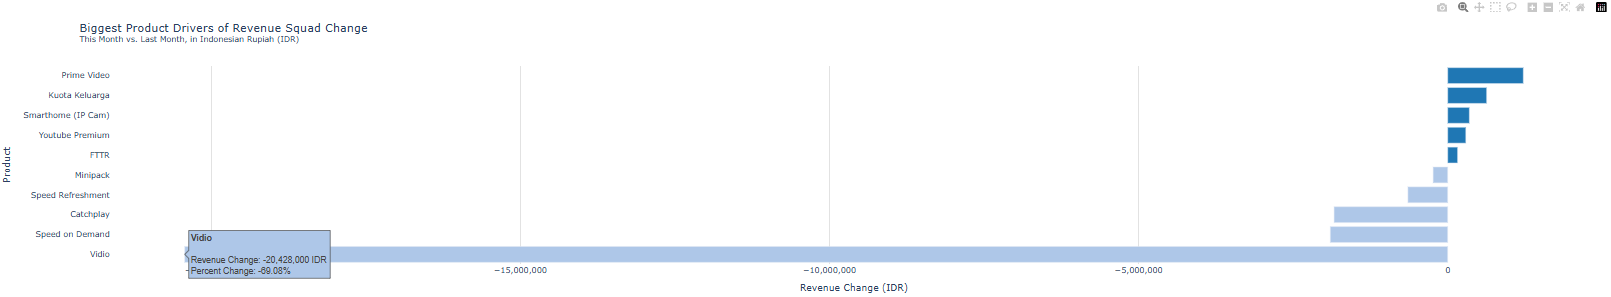
Total `rev squad` revenue decreased by **IDR 22,269,331 (-42.6%)**, from IDR 52,239,543 last month to IDR 29,970,212 this month.

Key drivers of this change include:

*   **Top 3 Positive Drivers:**
    *   Prime Video: +IDR 1,222,519
    *   Kuota Keluarga: +IDR 630,000
    *   Smarthome (IP Cam): +IDR 350,000

*   **Top 3 Negative Drivers:**
    *   Vidio: -IDR 20,428,000
    *   Speed on Demand: -IDR 1,899,405
    *   Catchplay: -IDR 1,838,000

**Bottom line:** Revenue saw a significant month-over-month decline, almost entirely driven by the sharp drop in performance from the Vidio product.

**Next actions:**
*   Investigate the root cause of the IDR 20.4M drop in Vidio revenue (e.g., end of a promotion, market shift).
*   Analyze performance factors for Speed on Demand and Catchplay to understand their decline.
*   Identify and scale the successful tactics driving growth for Prime Video.

**Caveats:** Analysis is based on product-level data provided.
**Confidence:** High

For a full breakdown, see the chart: `/content/exports/Campaign/chart/product-rev-drivers-20250917101500-5d25859c.html`.
<br><br>

###Total response time
154.99s = 2m 34.99s
<br>